# Предсказание курса биткоина с использованием CatBoost и BERTA

Этот ноутбук демонстрирует, как предсказывать цены биткоина, комбинируя:
1. Анализ текста новостных заголовков с использованием модели BERTA от Hugging Face
2. Традиционные признаки, обрабатываемые с помощью CatBoost

Мы сгенерируем эмбеддинги из новостных данных и объединим их с другими релевантными признаками для обучения прогностической модели.

## 1. Установка необходимых библиотек

Установим необходимые пакеты с помощью `uv`.

In [1]:
# Установка необходимых библиотек с помощью uv
!pip install catboost transformers pandas numpy scikit-learn torch matplotlib seaborn yfinance tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [2]:
!gdown 11uN4LY244grxFcAB56XyG-L4HTJYT7ge
!gdown 1s7vRks9RLf_oYnKR6p0xIyQSL-ATuwVq

Downloading...
From (original): https://drive.google.com/uc?id=11uN4LY244grxFcAB56XyG-L4HTJYT7ge
From (redirected): https://drive.google.com/uc?id=11uN4LY244grxFcAB56XyG-L4HTJYT7ge&confirm=t&uuid=b38562f6-3d2c-4782-91e4-6f2ba928f633
To: /kaggle/working/CoinTelegraph_Articles.json
100%|████████████████████████████████████████| 108M/108M [00:03<00:00, 35.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1s7vRks9RLf_oYnKR6p0xIyQSL-ATuwVq
To: /kaggle/working/BitcoinMagazine_Articles.json
100%|██████████████████████████████████████| 74.5M/74.5M [00:01<00:00, 44.3MB/s]


## 2. Импорт библиотек

Импортируем все необходимые библиотеки для нашего анализа.

In [3]:
# Базовая обработка данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta

# Модели и метрики
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Обработка текста и эмбеддинги
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import re
import nltk
from nltk.corpus import stopwords
from tqdm.auto import tqdm

tqdm.pandas()

# Данные биткоина
import yfinance as yf

# Конфигурация
import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")

nltk.download("stopwords")
nltk.download("punkt_tab")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 3. Загрузка и предобработка новостных данных

Загрузим наши новостные данные и выполним предобработку текста:
- Очистка и нормализация
- Удаление стоп-слов
- Токенизация для входа в модель

In [4]:
def load_json_articles(file_path: str) -> list:
    with open(file_path, "r", encoding="utf-8") as f:
        articles = json.load(f)
    return articles


# Загрузка статей из обоих источников
print("Загрузка статей Bitcoin Magazine...")
try:
    btc_magazine_articles = load_json_articles("BitcoinMagazine_Articles.json")
    print(f"Загружено {len(btc_magazine_articles)} статей из Bitcoin Magazine")
except Exception as e:
    print(f"Ошибка загрузки статей Bitcoin Magazine: {e}")
    btc_magazine_articles = []

print("\nЗагрузка статей CoinTelegraph...")
try:
    cointelegraph_articles = load_json_articles("CoinTelegraph_Articles.json")
    print(f"Загружено {len(cointelegraph_articles)} статей из CoinTelegraph")
except Exception as e:
    print(f"Ошибка загрузки статей CoinTelegraph: {e}")
    cointelegraph_articles = []


def articles_to_dataframe(articles: list, source_name: str) -> pd.DataFrame:
    data = []
    # Применяем разную логику парсинга в зависимости от источника
    if source_name == "CoinTelegraph":
        for article in tqdm(articles, desc=f"Обработка {source_name}"):
            if "title" in article and "published_time" in article:
                try:
                    date = pd.to_datetime(article["published_time"])
                    data.append(
                        {
                            "date": date,
                            "headline": article.get("title", ""),
                            "content": article.get("text", ""),
                            "url": article.get("url", ""),
                            "views": article.get("views", 0),
                            "source": source_name,
                        }
                    )
                except:
                    pass
    elif source_name == "Bitcoin Magazine":
        for article in tqdm(articles, desc=f"Обработка {source_name}"):
            if "title" in article and "published_time" in article:
                try:
                    date = pd.to_datetime(article["published_time"])
                    data.append(
                        {
                            "date": date,
                            "headline": article.get("title", ""),
                            "content": article.get("text", ""),
                            "url": article.get("url", ""),
                            "source": source_name,
                        }
                    )
                except:
                    pass
    return pd.DataFrame(data)


# Преобразование статей в DataFrame
btc_magazine_df = articles_to_dataframe(btc_magazine_articles, "Bitcoin Magazine")
cointelegraph_df = articles_to_dataframe(cointelegraph_articles, "CoinTelegraph")

# Объединение всех источников новостей
news_data = pd.concat([btc_magazine_df, cointelegraph_df], ignore_index=True)

# Сортировка по дате
news_data = news_data.sort_values("date")

print(f"\nВсего новостных статей: {len(news_data)}")
print("Диапазон дат:", news_data["date"].min(), "до", news_data["date"].max())
print("\nПример данных:")
print(news_data.head())


def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    stop_words = set(stopwords.words("english"))
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return " ".join(filtered_tokens)


# Применение очистки текста с использованием progress_apply
print("\nОчистка текстовых данных...")
news_data["clean_headline"] = news_data["headline"].progress_apply(clean_text)
news_data["clean_content"] = news_data["content"].progress_apply(clean_text)

# Вывод примера очищенных данных
print("\nПримеры очищенных текстов:")
print(news_data[["clean_headline", "clean_content"]].head(2))


Загрузка статей Bitcoin Magazine...
Загружено 12269 статей из Bitcoin Magazine

Загрузка статей CoinTelegraph...
Загружено 27158 статей из CoinTelegraph


Обработка Bitcoin Magazine:   0%|          | 0/12269 [00:00<?, ?it/s]

Обработка CoinTelegraph:   0%|          | 0/27158 [00:00<?, ?it/s]


Всего новостных статей: 39420
Диапазон дат: 2012-02-28 06:06:16-05:00 до 2025-03-07 21:38:56-05:00

Пример данных:
                            date                                     headline  \
12261  2012-02-28 06:06:16-05:00  The Wasted Electricity Objection To Bitcoin   
12260  2012-02-28 11:34:40-05:00      Bitcoin Adoption Opportunity: Teenagers   
12259  2012-02-28 22:46:22-05:00                     Bitcoin Exchange Wallets   
12258  2012-02-28 23:24:16-05:00          Client Side Secured Browser Wallets   
12257  2012-02-29 02:59:35-05:00          Lightweight Bitcoin Clients/Wallets   

                                                 content  \
12261  One of the main arguments in favor of fiat cur...   
12260  If Bitcoin is to achieve mainstream success it...   
12259  In a managed online wallet, everything is cont...   
12258  Client side browser wallets almost exactly res...   
12257  Lightweight bitcoin clients differ mainly in t...   

                                    

  0%|          | 0/39420 [00:00<?, ?it/s]

  0%|          | 0/39420 [00:00<?, ?it/s]


Примеры очищенных текстов:
                               clean_headline  \
12261    wasted electricity objection bitcoin   
12260  bitcoin adoption opportunity teenagers   

                                           clean_content  
12261  one main arguments favor fiat currencies oppos...  
12260  bitcoin achieve mainstream success stop limite...  


## 4. Загрузка предобученной модели BERTA из Hugging Face

Будем использовать модель sergeyzh/BERTA из Hugging Face, которая специально настроена для русского текста.

In [5]:
# Загрузка предобученной модели BERTA из Hugging Face
model_name = "sergeyzh/BERTA"

tokenizer = AutoTokenizer.from_pretrained(model_name)
berta_model = AutoModel.from_pretrained(model_name)

# Перенос модели на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
berta_model = berta_model.to(device)
print(f"Используется устройство: {device}")

tokenizer_config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

2025-06-15 12:25:35.138268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749990335.302852      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749990335.350232      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

Используется устройство: cuda


In [6]:
def pool(
    hidden_state: torch.Tensor, mask: torch.Tensor, pooling_method: str = "mean"
) -> torch.Tensor:
    if pooling_method == "mean":
        s = torch.sum(hidden_state * mask.unsqueeze(-1).float(), dim=1)
        d = mask.sum(axis=1, keepdim=True).float()
        return s / d
    elif pooling_method == "cls":
        return hidden_state[:, 0]
    elif pooling_method == "max":
        masked = hidden_state * mask.unsqueeze(-1).float()
        masked_fill = masked + (1 - mask.unsqueeze(-1).float()) * -1e9
        return torch.max(masked_fill, dim=1)[0]
    else:
        raise ValueError(f"Неизвестный метод пулинга: {pooling_method}")

## 5. Генерация текстовых эмбеддингов

Теперь используем модель BERTA для генерации эмбеддингов нашего новостного текста.

In [7]:
def get_bert_embeddings(
    texts: list, max_length: int = 256, pooling_method: str = "mean"
) -> np.ndarray:
    encoded_input = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        model_output = berta_model(**encoded_input)

    sentence_embeddings = pool(
        model_output.last_hidden_state,
        encoded_input["attention_mask"],
        pooling_method=pooling_method,
    )

    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    return sentence_embeddings.cpu().numpy()


# Генерация эмбеддингов для заголовков и содержания новостей
batch_size = 128  # Меньший размер батча для предотвращения проблем с памятью
headline_embeddings = []
content_embeddings = []

print("Генерация эмбеддингов заголовков...")
for i in tqdm(range(0, len(news_data), batch_size)):
    batch_texts = news_data["clean_headline"][i : i + batch_size].tolist()
    batch_embeddings = get_bert_embeddings(batch_texts, pooling_method="mean")
    headline_embeddings.extend(batch_embeddings)

print("\nГенерация эмбеддингов содержания...")
for i in tqdm(range(0, len(news_data), batch_size)):
    batch_texts = news_data["clean_content"][i : i + batch_size].fillna("").tolist()
    batch_embeddings = get_bert_embeddings(batch_texts, pooling_method="mean")
    content_embeddings.extend(batch_embeddings)

# Преобразование эмбеддингов в массивы numpy
headline_embeddings = np.array(headline_embeddings)
content_embeddings = np.array(content_embeddings)

print(f"Размерность эмбеддингов заголовков: {headline_embeddings.shape}")
print(f"Размерность эмбеддингов содержания: {content_embeddings.shape}")

Генерация эмбеддингов заголовков...


  0%|          | 0/308 [00:00<?, ?it/s]


Генерация эмбеддингов содержания...


  0%|          | 0/308 [00:00<?, ?it/s]

Размерность эмбеддингов заголовков: (39420, 768)
Размерность эмбеддингов содержания: (39420, 768)


## 6. Подготовка данных для CatBoost

Теперь объединим текстовые эмбеддинги с другими релевантными признаками, такими как исторические данные цен, объемы торгов и технические индикаторы, для подготовки нашего набора данных к обучению.

In [8]:
csv_path = "/kaggle/input/bitcoin-historical-data/btcusd_1-min_data.csv"

def load_daily_btc(csv_path: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Из минутных данных строим дневные OHLCV и возвращаем
    датафрейм с колонками: date, price, volume, open, high, low.
    Ограничиваем диапазон [start_date, end_date] (оба конца включительно).
    """
    df = pd.read_csv(csv_path)
    
    # В разных версиях файла столбец объёма может называться Volume или Volume_(BTC)
    volume_col = "Volume" if "Volume" in df.columns else "Volume_(BTC)"
    
    # 1) Переводим Unix-время → datetime (UTC)
    df["datetime"] = pd.to_datetime(df["Timestamp"], unit="s", utc=True)
    
    # 2) Оставляем нужные колонки и ставим индекс
    df = (df[["datetime", "Open", "High", "Low", "Close", volume_col]]
            .rename(columns={volume_col: "Volume"})
            .set_index("datetime"))
    
    # 3) Ресэмпл до дневных свечей
    daily = (
        df.resample("1D")
          .agg({"Open": "first",
                "High": "max",
                "Low":  "min",
                "Close":"last",
                "Volume":"sum"})
          .dropna(subset=["Open"])          # дни без торгов отбрасываем
          .reset_index()
    )
    
    # 4) Приводим к «вашему» формату
    daily = (daily
             .assign(date=lambda x: x["datetime"].dt.date)
             .rename(columns={
                 "Close": "price",
                 "Open":  "open",
                 "High":  "high",
                 "Low":   "low",
                 "Volume":"volume"
             })
             .drop(columns=["datetime"])
    )
    
    # 5) Фильтрация по нужному диапазону
    mask = ((daily["date"] >= pd.to_datetime(start_date).date()) &
            (daily["date"] <= pd.to_datetime(end_date).date()))
    return daily.loc[mask].reset_index(drop=True)

# --- вызываем ----

# 1. Преобразуем даты новостей в формат date (без времени)
def prepare_news_dates(df: pd.DataFrame) -> pd.DataFrame:
    df["date"] = pd.to_datetime(df["date"], utc=True).dt.date
    return df

news_data = prepare_news_dates(news_data)

# 2. Определяем диапазон дат для загрузки цен
min_date = news_data["date"].min()
max_date = news_data["date"].max()

# Начало: на 30 дней раньше первой новости
start_dt = pd.to_datetime(min_date) - pd.Timedelta(days=30)
# Конец: на 1 день позже последней новости (включаем её)
end_dt   = pd.to_datetime(max_date) + pd.Timedelta(days=1)

start_date = start_dt.strftime("%Y-%m-%d")
end_date   = end_dt.strftime("%Y-%m-%d")
print(f"Загрузка данных о ценах биткоина с {start_date} по {end_date}")

btc_price = load_daily_btc(csv_path, start_date, end_date)

print(f"Загружено {len(btc_price)} дневных свечей BTC из CSV")
print(btc_price.head())

Загрузка данных о ценах биткоина с 2012-01-29 по 2025-03-09
Загружено 4789 дневных свечей BTC из CSV
   open  high   low  price      volume        date
0  4.91  5.90  4.91   5.90    1.854846  2012-01-29
1  5.90  5.90  5.30   5.58   22.380000  2012-01-30
2  5.58  6.22  5.55   5.55  104.718333  2012-01-31
3  5.55  6.00  3.80   5.99   13.552446  2012-02-01
4  5.99  6.26  5.54   6.26  123.582638  2012-02-02


In [9]:
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """Добавляет технические индикаторы к DataFrame с ценовыми данными.

    Args:
        df: DataFrame с ценовыми данными

    Returns:
        pd.DataFrame: DataFrame с добавленными техническими индикаторами
    """
    # Простые скользящие средние
    df["SMA7"] = df["price"].rolling(window=7).mean()
    df["SMA30"] = df["price"].rolling(window=30).mean()

    # Моментум цены
    df["price_momentum"] = df["price"].pct_change(periods=7)

    # Волатильность
    df["volatility"] = df["price"].rolling(window=7).std()

    # Изменение объема торгов
    df["volume_change"] = df["volume"].pct_change()

    # Диапазон цен
    df["daily_range"] = (df["high"] - df["low"]) / df["open"]

    # Индекс относительной силы (RSI)
    delta = df["price"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    return df

In [10]:
## 6. Подготовка данных для CatBoost


btc_ticker = yf.Ticker("BTC-USD")


# 4. Подготовка эмбеддингов для объединения
# Группируем по дате и усредняем эмбеддинги за день
headline_emb_df = pd.DataFrame(
    headline_embeddings,
    columns=[f"h_emb_{i}" for i in range(headline_embeddings.shape[1])]
)
headline_emb_df["date"] = news_data["date"].values

daily_head = headline_emb_df.groupby("date").mean().reset_index()

content_emb_df = pd.DataFrame(
    content_embeddings,
    columns=[f"c_emb_{i}" for i in range(content_embeddings.shape[1])]
)
content_emb_df["date"] = news_data["date"].values

daily_content = content_emb_df.groupby("date").mean().reset_index()

# 5. Объединяем цены и эмбеддинги
daily_emb = pd.merge(daily_head, daily_content, on="date", how="inner")
merged_data = pd.merge(btc_price, daily_emb, on="date", how="inner")
print(f"Размерность объединенных данных: {merged_data.shape}")

# 6. Добавляем технические индикаторы и убираем NaN
merged_data = add_technical_indicators(merged_data)
merged_data = merged_data.dropna()

# 7. Определяем целевые переменные
merged_data["target_pct_change"] = merged_data["price"].pct_change().shift(-1)
merged_data["target_direction"] = (merged_data["target_pct_change"] > 0).astype(int)
merged_data["target_price"] = merged_data["price"].shift(-1)
merged_data = merged_data.dropna()
print(f"Итоговая размерность данных после предобработки: {merged_data.shape}")



# 8. Создаём признаки и делим на train/test
price_features = [
    "price", "volume", "SMA7", "SMA30", "price_momentum",
    "volatility", "volume_change", "daily_range", "RSI"
]

headline_cols = [col for col in merged_data.columns if col.startswith("h_emb_")]
headline_data = merged_data[headline_cols]
pca_headline = PCA(n_components=20)
headline_pca = pca_headline.fit_transform(headline_data)
headline_pca_df = pd.DataFrame(headline_pca, columns=[f"h_pca_{i}" for i in range(20)])

# Применяем PCA к эмбеддингам содержания
content_cols = [col for col in merged_data.columns if col.startswith("c_emb_")]
content_data = merged_data[content_cols]
pca_content = PCA(n_components=20)
content_pca = pca_content.fit_transform(content_data)
content_pca_df = pd.DataFrame(content_pca, columns=[f"c_pca_{i}" for i in range(20)])

# Сбрасываем индекс перед добавлением столбцов PCA
merged_data = merged_data.reset_index(drop=True)
headline_pca_df = headline_pca_df.reset_index(drop=True)
content_pca_df = content_pca_df.reset_index(drop=True)

# Добавляем столбцы PCA в merged_data
for col in headline_pca_df.columns:
    merged_data[col] = headline_pca_df[col].values

for col in content_pca_df.columns:
    merged_data[col] = content_pca_df[col].values

# Определяем все признаки
embedding_pca_features = [
    col
    for col in merged_data.columns
    if col.startswith("h_pca_") or col.startswith("c_pca_")
]
all_features = price_features + embedding_pca_features

# Подготовка признаков и целевой переменной
X = merged_data[all_features]
y_price = merged_data["target_price"]  # Для регрессии (предсказание цены)
y_direction = merged_data["target_direction"]  # Для классификации (направление цены)

# Разделение данных
train_size = int(len(merged_data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_price_train, y_price_test = y_price[:train_size], y_price[train_size:]
y_direction_train, y_direction_test = y_direction[:train_size], y_direction[train_size:]

print(f"\nОбучающая выборка: {X_train.shape}, Тестовая выборка: {X_test.shape}")
print(
    f"Распределение направления цены в обучающей выборке: {y_direction_train.value_counts()}"
)
print(
    f"Распределение направления цены в тестовой выборке: {y_direction_test.value_counts()}"
)

Размерность объединенных данных: (4352, 1542)
Итоговая размерность данных после предобработки: (4320, 1552)

Обучающая выборка: (3456, 49), Тестовая выборка: (864, 49)
Распределение направления цены в обучающей выборке: target_direction
1    1841
0    1615
Name: count, dtype: int64
Распределение направления цены в тестовой выборке: target_direction
1    452
0    412
Name: count, dtype: int64


## 7. Обучение моделей CatBoost

Обучим две модели:
1. Регрессионную модель для предсказания точной цены биткоина
2. Классификационную модель для предсказания направления движения цены (вверх или вниз)

Обучение модели предсказания цены...
0:	learn: 15327.4848990	test: 44907.2017635	best: 44907.2017635 (0)	total: 60.4ms	remaining: 30.1s
100:	learn: 1409.7353309	test: 16578.3693893	best: 16578.3693893 (100)	total: 624ms	remaining: 2.46s
200:	learn: 781.3527938	test: 14296.6935670	best: 14296.6935670 (200)	total: 1.2s	remaining: 1.78s
300:	learn: 679.3763534	test: 13940.3572779	best: 13940.3572779 (300)	total: 1.76s	remaining: 1.17s
400:	learn: 596.3671744	test: 13874.4927010	best: 13874.0905096 (399)	total: 2.33s	remaining: 575ms
499:	learn: 520.5681288	test: 13867.6364873	best: 13861.3676153 (457)	total: 2.92s	remaining: 0us

bestTest = 13861.36762
bestIteration = 457

Shrink model to first 458 iterations.

Обучение модели предсказания направления цены...
0:	learn: 0.6921431	test: 0.6928417	best: 0.6928417 (0)	total: 6.86ms	remaining: 3.42s
100:	learn: 0.6250396	test: 0.6917413	best: 0.6905905 (53)	total: 651ms	remaining: 2.57s
200:	learn: 0.5723605	test: 0.6932777	best: 0.6905905 (53

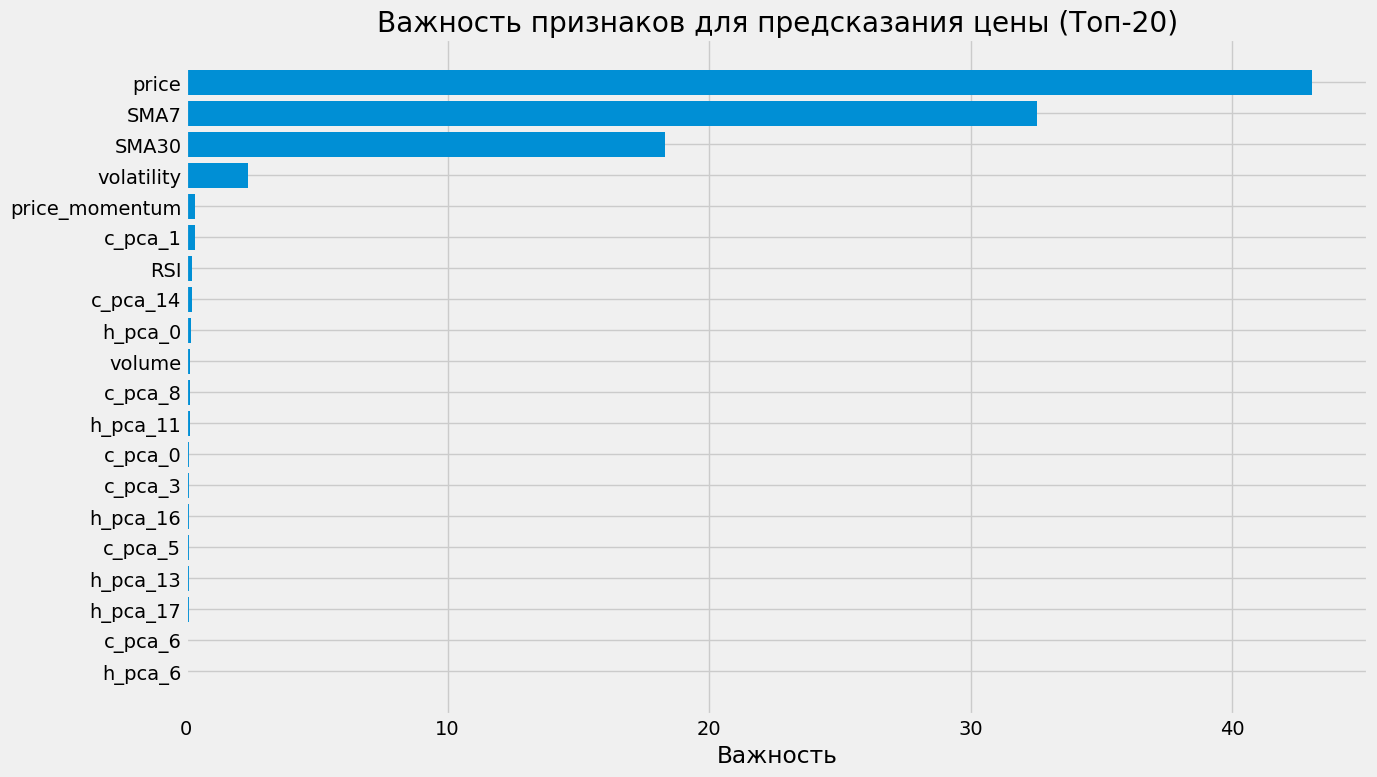

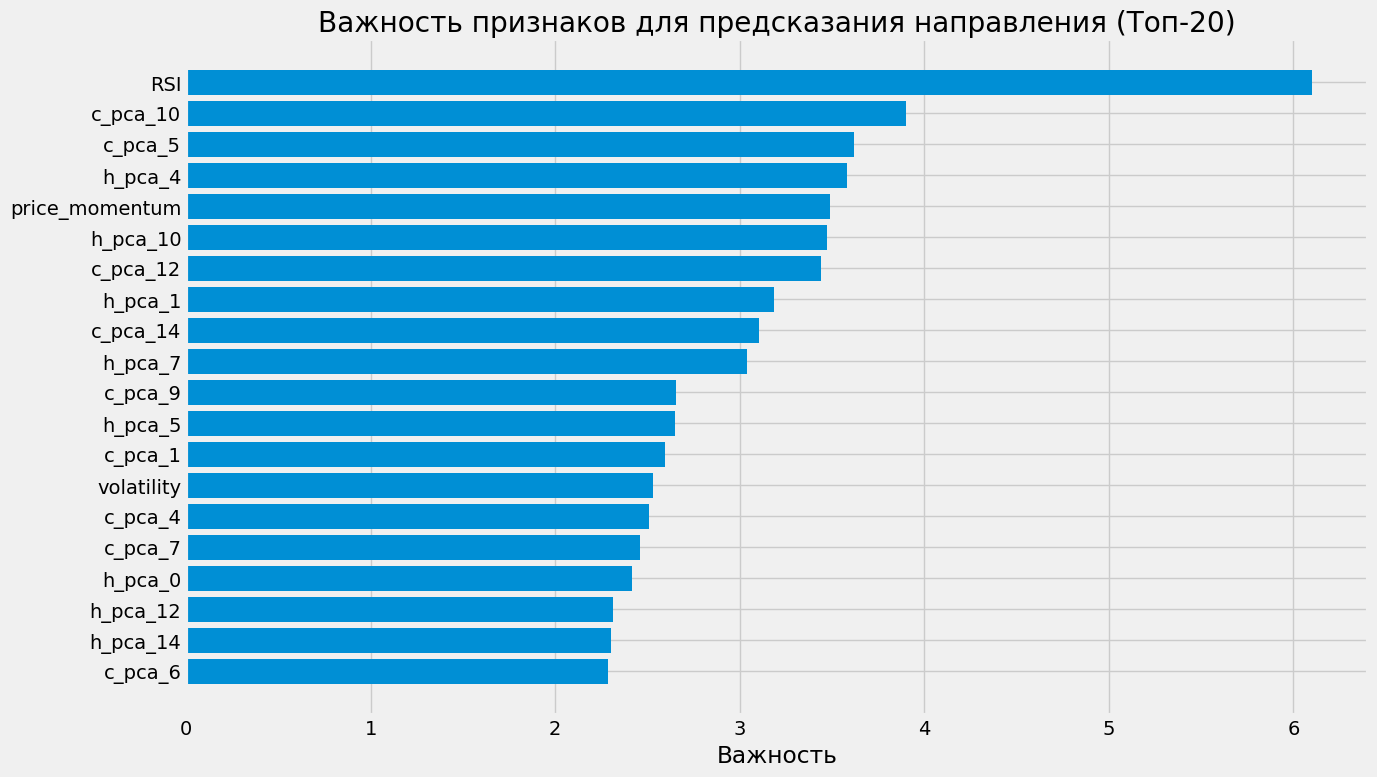

In [11]:
# 1. Обучение CatBoost регрессора для предсказания цены
print("Обучение модели предсказания цены...")
catboost_regressor = CatBoostRegressor(
    iterations=500, learning_rate=0.03, depth=6, loss_function="RMSE", verbose=100
)

# Обучение модели
catboost_regressor.fit(X_train, y_price_train, eval_set=(X_test, y_price_test))

# Делаем предсказания цены
y_price_pred = catboost_regressor.predict(X_test)

# 2. Обучение CatBoost классификатора для предсказания направления
print("\nОбучение модели предсказания направления цены...")
catboost_classifier = CatBoostClassifier(
    iterations=500, learning_rate=0.03, depth=6, loss_function="Logloss", verbose=100
)

# Обучение классификатора
catboost_classifier.fit(X_train, y_direction_train, eval_set=(X_test, y_direction_test))

# Делаем предсказания направления
y_direction_pred = catboost_classifier.predict(X_test)

# График важности признаков для модели предсказания цены
plt.figure(figsize=(14, 8))
feature_importance = catboost_regressor.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({"Признак": feature_names, "Важность": feature_importance})
importance_df = importance_df.sort_values("Важность", ascending=False).head(20)

plt.barh(importance_df["Признак"], importance_df["Важность"])
plt.title("Важность признаков для предсказания цены (Топ-20)")
plt.xlabel("Важность")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# График важности признаков для модели предсказания направления
plt.figure(figsize=(14, 8))
feature_importance = catboost_classifier.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({"Признак": feature_names, "Важность": feature_importance})
importance_df = importance_df.sort_values("Важность", ascending=False).head(20)

plt.barh(importance_df["Признак"], importance_df["Важность"])
plt.title("Важность признаков для предсказания направления (Топ-20)")
plt.xlabel("Важность")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Оценка моделей

Теперь оценим обе модели предсказания, используя соответствующие метрики.

Оценка модели предсказания цены...
Корень среднеквадратичной ошибки (RMSE): $13861.37
Средняя абсолютная ошибка (MAE): $6958.02
Коэффициент детерминации (R²): 0.7063
Средняя процентная ошибка: 9.24%

Оценка модели предсказания направления цены...
Точность: 0.5104

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.47      0.25      0.33       412
           1       0.52      0.75      0.62       452

    accuracy                           0.51       864
   macro avg       0.50      0.50      0.47       864
weighted avg       0.50      0.51      0.48       864


Матрица ошибок:
[[102 310]
 [113 339]]


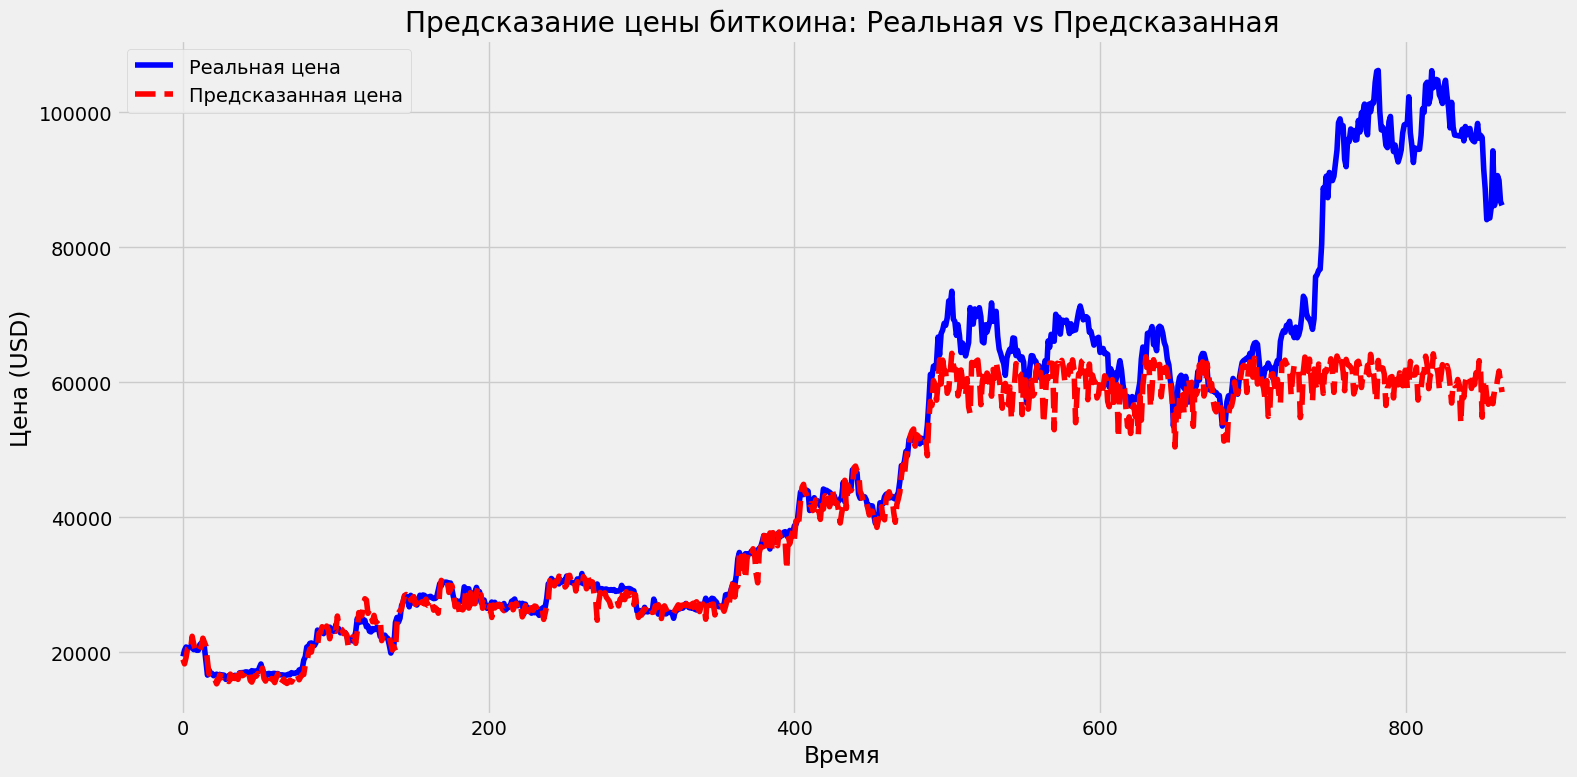

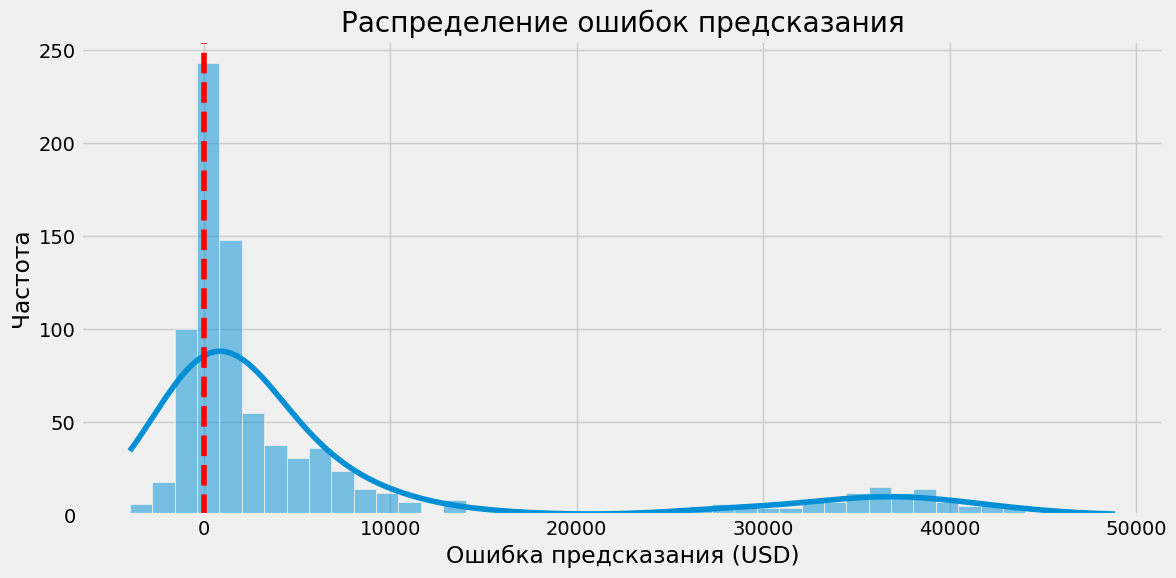

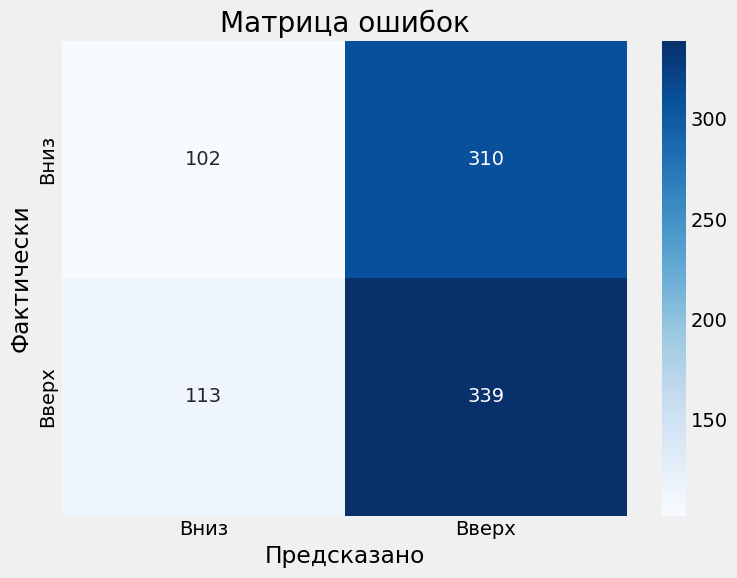

In [12]:
# Оценка регрессионной модели (предсказание цены)
print("Оценка модели предсказания цены...")
rmse = np.sqrt(mean_squared_error(y_price_test, y_price_pred))
mae = mean_absolute_error(y_price_test, y_price_pred)
r2 = r2_score(y_price_test, y_price_pred)

print(f"Корень среднеквадратичной ошибки (RMSE): ${rmse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): ${mae:.2f}")
print(f"Коэффициент детерминации (R²): {r2:.4f}")

# Расчет процентной ошибки
y_test_array = np.array(y_price_test)
percentage_error = np.abs((y_test_array - y_price_pred) / y_test_array) * 100
mean_percentage_error = np.mean(percentage_error)
print(f"Средняя процентная ошибка: {mean_percentage_error:.2f}%")

# Оценка классификационной модели (предсказание направления)
print("\nОценка модели предсказания направления цены...")
accuracy = accuracy_score(y_direction_test, y_direction_pred)
print(f"Точность: {accuracy:.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_direction_test, y_direction_pred))

print("\nМатрица ошибок:")
conf_mat = confusion_matrix(y_direction_test, y_direction_pred)
print(conf_mat)

# График реальных и предсказанных цен
plt.figure(figsize=(16, 8))
plt.plot(y_price_test.values, label="Реальная цена", color="blue")
plt.plot(y_price_pred, label="Предсказанная цена", color="red", linestyle="--")
plt.title("Предсказание цены биткоина: Реальная vs Предсказанная")
plt.xlabel("Время")
plt.ylabel("Цена (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# График распределения ошибок предсказания
plt.figure(figsize=(12, 6))
error = y_price_test.values - y_price_pred
sns.histplot(error, kde=True)
plt.title("Распределение ошибок предсказания")
plt.xlabel("Ошибка предсказания (USD)")
plt.ylabel("Частота")
plt.axvline(x=0, color="red", linestyle="--")
plt.grid(True)
plt.tight_layout()
plt.show()

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Вниз", "Вверх"],
    yticklabels=["Вниз", "Вверх"],
)
plt.title("Матрица ошибок")
plt.xlabel("Предсказано")
plt.ylabel("Фактически")
plt.tight_layout()
plt.show()

In [13]:
catboost_regressor.save_model("catboost_regressor.cbm")

# По желанию: сохранить в формате JSON
catboost_regressor.save_model("catboost_regressor.json", format="json")

# Или — с помощью pickle
import pickle
with open("catboost_regressor.pkl", "wb") as f:
    pickle.dump(catboost_regressor, f)

In [14]:
catboost_classifier.save_model("catboost_classifier.cbm")

# В формате JSON
catboost_classifier.save_model("catboost_classifier.json", format="json")

# Через pickle (альтернативный вариант)
import pickle
with open("catboost_classifier.pkl", "wb") as f:
    pickle.dump(catboost_classifier, f)


## Заключение

В этом ноутбуке мы создали модель предсказания курса биткоина, используя:

1. Текстовые эмбеддинги из новостных статей с помощью модели BERTA от sergeyzh
2. Исторические данные о цене и объеме торгов биткоина
3. Технические индикаторы рынка

Мы обучили две модели CatBoost:
- Регрессионную модель для предсказания точной цены биткоина
- Классификационную модель для предсказания направления движения цены (вверх или вниз)

Результаты показывают, что комбинирование новостного сентимента с техническими индикаторами позволяет достичь лучших результатов, чем использование только одного типа данных./